# We are going to try and calculate the expected shift in Q using steve's method

In [2]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import numpy as np
from scipy.constants import c
import matplotlib.pyplot as plt
import legume
legume.set_backend('autograd')
import autograd.numpy as npa
import optomization
import json
from optomization.utils import NG
import matplotlib as mpl

# Disable LaTeX but use Computer Modern fonts
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern math fonts
mpl.rcParams['font.family'] = 'STIXGeneral'  # Use STIX fonts (similar to Computer Modern)

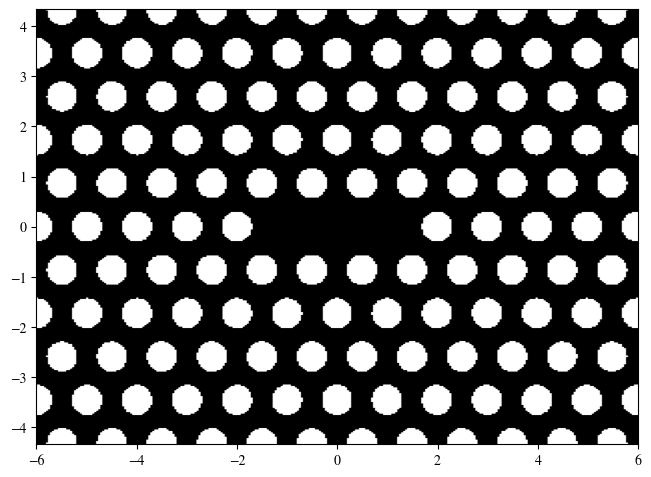

In [3]:
def L3(Nx=10,Ny=10,ra=.3,eps_b=3.4638**2,dslab=220/420,x_shift=0,y_shift=0):
    lattice = legume.Lattice(npa.array([Nx,0]),npa.array([0,Ny*npa.sqrt(3)/2]))

    #now we define a photonic crystal that goes over our lattice and add the one layer of our W1 waveguide
    phc = legume.PhotCryst(lattice)
    phc.add_layer(d=dslab,eps_b=eps_b)
    for i in np.linspace(-Ny//2,Ny//2,Ny,endpoint=False):
        for j in np.linspace(-Nx//2,Nx//2,Nx,endpoint=False):
            
            #skip the middle holes
            if (j==-1 or j==0 or j==1) and i==0:
                continue
        
            #move the hole over by half a unit cell if they are on odd rows
            if i%2==1:
                x = j+.5
            else:
                x = j

            #the y component should be scaled by the factor of np.sqrt(3)/2
            y = i*npa.sqrt(3)/2
            
            #get the radius of the hole
            ri = ra

            #we want to shift the holes on either side of the defect 
            if j==2 and i==0:
                x += x_shift
                y += y_shift

            #now we can add a circle with the given positions
            phc.add_shape(legume.Circle(x_cent=x,y_cent=y,r=ri))

    return(phc)

phc = L3(Nx=12,Ny=10,ra=.3,eps_b=3.4638**2,dslab=150/266)
_ =legume.viz.eps_xy(phc,Nx=300,Ny=300)

In [3]:
gmode_inds = [0]
gmeParams = {'verbose':True,'numeig':200,'compute_im':True,'gmode_inds':gmode_inds,'kpoints':npa.array([[0],[0]])}

phc = L3()
gme = legume.GuidedModeExp(phc,2.01)
gme.run(**gmeParams)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 1099 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'         │ 0.079    │ │--------------------│    0% │
│ Inverse matrix of Fourier-space permittivity                │ 0.469    │ │--------------------│    3% │
│ Matrix diagionalization using the 'eigh' solver             │ 15.110   │ │██████████████████--│   94% │
│ Creating GME matrix                                         │ 0.339    │ │--------------------│    2% │
├─────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 1 k-points      │ 16.003   │ │████████████████████│  100% │
└─────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 1099 plane waves and 1 guided modes     ┃ Time (s) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Total time for imaginary part of frequencies for 200 eigenmodes │ 8.308    │
└─────────────────────────────────────────────────────────────────┴──────────┘

In [4]:
def calcQ(gme,k,n):
    return(gme.freqs[k,n]/2/gme.freqs_im[k,n])

5281.445389919089


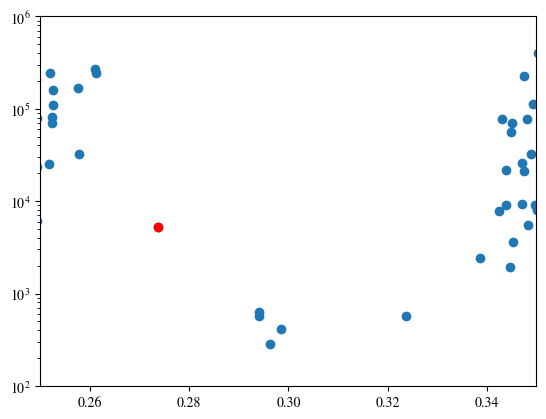

In [5]:
Qs = gme.freqs/2/gme.freqs_im
plt.plot(gme.freqs[0],Qs.T,'o')
plt.plot(gme.freqs[0,100],Qs.T[100],'or')
plt.xlim(0.25,0.35)
plt.ylim(1E2,1E6)
plt.yscale('log')

print(gme.freqs[0,100]/2/gme.freqs_im[0,100])

We have now calculated the Q value, so lets get the manual distribution by imparting a shift by some amount in a random angle 

In [6]:
#first we need to define a new function for the W1 that shift the holes in different directions
def L3_shifted(shift=x_shift,y_shift=y_shift):

    phc = L3()
    for circle in phc.layers[0].shapes:
        ampShift = npa.random.normal(loc=0,scale=sigma)
        circle.x_cent += sigma*npa.cos(npa.random.uniform(0,2*npa.pi))
        circle.y_cent += sigma*npa.sin(npa.random.uniform(0,2*npa.pi))
    return(phc)

sigmas = [0.0014,0.005,0.015]
QsDict = {}
for sigma in sigmas:
    Qs = []
    for i in range(50):
        phc = L3_shifted(sigma=sigma)
        gme = legume.GuidedModeExp(phc,2.01)
        gme.run(gmode_inds=[0],numeig=200,compute_im=True,verbose=False,kpoints=npa.array([[0],[0]]))
        Qs.append(gme.freqs[0,120]/2/gme.freqs_im[0,120])
    QsDict[str(sigma)] = Qs.copy()


NameError: name 'x_shift' is not defined

Sigma: 0.0014
Mean Q: 155400.51013403104
Std Q: 14919.913281159746
Sigma: 0.005
Mean Q: 68498.93970067715
Std Q: 23248.876049507242
Sigma: 0.015
Mean Q: 14607.258708171632
Std Q: 4561.074939363653


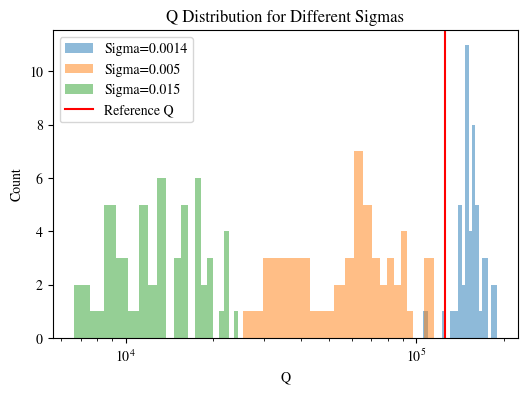

In [ ]:
plt.figure(figsize=(6,4))

for key, Qs in QsDict.items():
    print(f"Sigma: {key}")
    print("Mean Q:", np.mean(Qs))
    print("Std Q:", np.std(Qs))
    plt.hist(Qs, bins=20, alpha=0.5, label=f"Sigma={key}")

plt.axvline(125096, color='red', label='Reference Q')
plt.title("Q Distribution for Different Sigmas")
plt.xlabel("Q")
plt.ylabel("Count")
plt.xscale('log')
plt.legend()
plt.show()

# Calculate expectation value and variance 

Similar to what we have done for the backscattering and DOS calculation we are going to try and calculate the expectation value and variance using the field around the hole edge. Acording to Steve's formalism, the $$\Delta \tilde \omega_c=-\frac{\tilde \omega_c}{2}\int_s\left[(\varepsilon_1-\varepsilon_2)E_c^{||}(r)\cdot E_c^{||}(r)-(\varepsilon_1^{-1}-\varepsilon_2^{-1})D_c^\perp(r)\cdot D_c^\perp(r)\right](s(r)\cdot n(r))$$ where $s(r)$ is the displacement vector and $n(r)$ is the normal vector pointing from 1 to 2.

We will define our purturbation as changing our hole position in the direction $\theta \sim \mathcal{U}[0,2\pi]$ and the amount $\Delta r\sim \mathcal{N}(0,\sigma)$. This gives an expectation value for our change in the complex component of our frequency as $$\mathbb{E}[\Delta \tilde \omega_c]=-\frac{\tilde \omega_c}{2}\int_s\left[(\varepsilon_1-\varepsilon_2)E_c^{||}(r)\cdot E_c^{||}(r)-(\varepsilon_1^{-1}-\varepsilon_2^{-1})D_c^\perp(r)\cdot D_c^\perp(r)\right](\mathbb{E}[s(r)]\cdot n(r))$$

We will start by calculating the shift for one hole

In [ ]:
def runGME(phc,n,gmax,gmode_inds=[0]):
    gme = legume.GuidedModeExp(phc,gmax)
    gme.run(gmode_inds=gmode_inds,numeig=200,compute_im=True,verbose=False,kpoints=npa.array([[0],[0]]))
    return(gme.freqs[0,120],gme.freqs_im[0,120])


x_shifts = npa.linspace(-0.04, 0.04, 11)
freqs = []  
freqs_im = []
for x_shift in x_shifts:
    phc = L3(Nx=12,Ny=10,ra=.3,eps_b=3.4638**2,dslab=150/266,x_shift=x_shift)
    Q_shifted = runGME(phc,120,2.01,gmode_inds=[0])
    freqs.append(Q_shifted[0])
    freqs_im.append(Q_shifted[1])




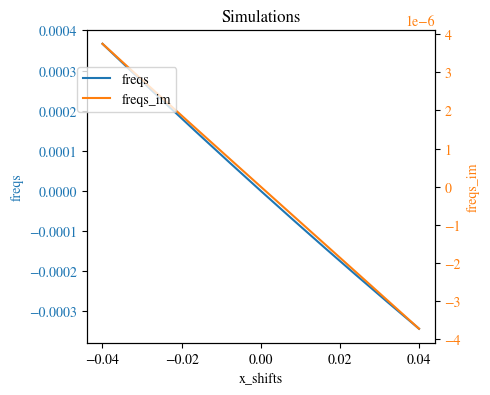

[-0.00938312 -0.00927785 -0.00917095 -0.00906214 -0.00895109 -0.00883744
 -0.00872078 -0.00860066 -0.00847658 -0.00834795]
[-9.44912309e-05 -9.39605353e-05 -9.35487813e-05 -9.32503997e-05
 -9.30586360e-05 -9.29652456e-05 -9.29601089e-05 -9.30307458e-05
 -9.31617063e-05 -9.33338032e-05]


In [82]:
fig, ax1 = plt.subplots(figsize=(5,4))

color = 'tab:blue'
ax1.set_xlabel('x_shifts')
ax1.set_ylabel('freqs', color=color)
ax1.plot(x_shifts, freqs-freqs[5], label='freqs', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('freqs_im', color=color)
ax2.plot(x_shifts, freqs_im-freqs_im[5], label='freqs_im', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Simulations')
fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.85))
plt.show()
print((np.array(freqs[:-1])-np.array(freqs[1:]))/(np.array(x_shifts[:-1])-np.array(x_shifts[1:])))
print((np.array(freqs_im[:-1])-np.array(freqs_im[1:]))/(np.array(x_shifts[:-1])-np.array(x_shifts[1:])))

In [4]:
def hole_borders(phc,phidiv=45):
    """
    returns the points at the hole borders
    """

    #get relevent information for computation
    shapes = phc.layers[0].shapes
    phis = npa.linspace(0,2*npa.pi,phidiv,endpoint=False)
    cphis = np.cos(phis); sphis = np.sin(phis)

    #get the array of hole atributes [xpos,ypos,r]
    holeCords = np.array([[s.x_cent, s.y_cent, s.r] for s in shapes])

    #get the coordinates of the hole borders
    # Compute the initial borders using broadcasting
    x_coords = holeCords[:, 0:1] + holeCords[:, 2:3] * cphis  # Add dimensions for broadcasting
    y_coords = holeCords[:, 1:2] + holeCords[:, 2:3] * sphis

    # Combine x and y coordinates
    initialBorders = np.stack([x_coords, y_coords], axis=-1)

    # Apply lattice corrections
    xCorrected = np.where(initialBorders[..., 0] > phc.lattice.a1[0] / 2, 
                         initialBorders[..., 0] - phc.lattice.a1[0], 
                         initialBorders[..., 0])
    yCorrected = np.where(initialBorders[..., 1] > phc.lattice.a2[0] / 2, 
                         initialBorders[..., 1] - phc.lattice.a2[0], 
                         initialBorders[..., 1])

    # Combine corrected coordinates
    borders = np.stack([xCorrected, yCorrected], axis=-1)

    return(borders, phis, holeCords[:,2])
    
def get_xyfield(gme,k,n,xys,z,field='E',components='xyz'):
    """
    returns the field at given points in the x-y plane at a given z
    """
    #setup 
    ft = {}
    ft['x'],ft['y'],ft['z'] = gme.ft_field_xy(field,k,n,z)
    fis = {}
    _, ind_unique = np.unique(gme.gvec,return_index=True,axis=1)

    #loop through adding the field
    for comp in components:
        if not (comp in fis.keys()):
            fis[comp] = np.zeros(xys[:,:,0].shape,dtype=np.complex128)
            for indg in ind_unique:
                fis[comp] += ft[comp][indg]*np.exp(1j*gme.gvec[0,indg]*xys[:,:,0]+1j*gme.gvec[1,indg]*xys[:,:,1])
        else:
            raise ValueError("component can be any combiation of xyz")

    return(fis)

In [ ]:
phc_original = L3(Nx=20,Ny=15,ra=.3,eps_b=3.4638**2,dslab=150/266)
gme_original = legume.GuidedModeExp(phc_original,3.01)
gme_original.run(gmode_inds=[0],numeig=20*15+1,compute_im=True,verbose=False,kpoints=npa.array([[0],[0]]))

In [182]:
hole_borders, phis, radii = hole_borders(phc_original)

In [70]:
fis = get_xyfield(gme_original,0,120,hole_borders[65][np.newaxis,:,:],phc_original.layers[0].d/2)

In [188]:
def calcShift(gme,
        k=0,
        n=120,
        xys=[],
        zs=[],
        phis=[],
        x_shift=0,
        y_shift=0
        ):

    #get the epilon values
    eps1 = 1                         #vacuum
    eps2 = gme.phc.layers[0].eps_b   #material

    #get the shift and normal vectors
    s = np.array([[x_shift,y_shift] for _ in phis])
    normal = np.array([[np.cos(f),np.sin(f)] for f in phis])

    integral = 0
    for i in range(len(zs)):
        #get the electric fields
        Es = get_xyfield(gme,k,n,xys,zs[i],field='E',components='xy')
        Ds = get_xyfield(gme,k,n,xys,zs[i],field='D',components='xy')
        
        #get the perpendicular and parallel components of the dispacement and electric field, respectively
        Espara = np.array([-np.sin(phis)*Es['x'],np.cos(phis)*Es['y']])
        Dsperp = np.array([np.cos(phis)*Ds['x'],np.sin(phis)*Ds['y']])
        

        #calculate the integrand
        integrand = ((eps2-eps1)*(np.sum(Espara*Espara, axis=0)[0])-((1/eps2)-(1/eps1))*(np.sum(Dsperp*Dsperp, axis=0)[0]))*np.sum(s * normal, axis=1)
        
        integral += np.sum(integrand)
    
    
    #integration constant 
    const = 0.3 * (phc.layers[0].d/len(zs))* (2*np.pi/len(phis))

    integral = -(gme.freqs[0,120]-1j*gme.freqs_im[0,120])/2*integral*const
    
    return(integral)

zs_original = np.linspace(0,phc_original.layers[0].d,12,endpoint=True)
zs_midpoints = zs_original[:-1] + (zs_original[1:] - zs_original[:-1])/2
integrals = []
for x_shift in x_shifts:
    integrals.append(calcShift(gme_original,k=0,n=120,xys=hole_borders[65][np.newaxis,:,:],zs=zs_midpoints,phis=phis,x_shift=x_shift))

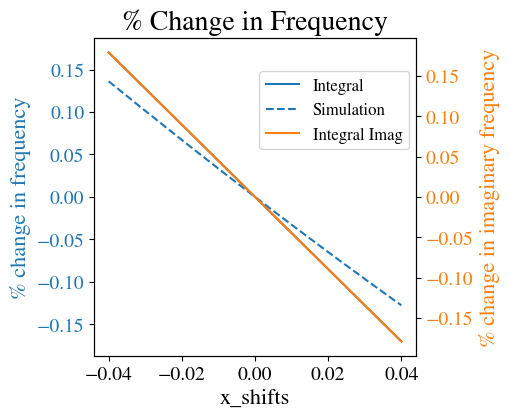

In [ ]:
fig, ax1 = plt.subplots(figsize=(5,4))


ax1.set_xlabel('x_shifts', fontsize=16)
ax1.set_ylabel('% change in frequency', color='C0', fontsize=16)
ax1.plot(x_shifts, np.real(integrals)/freqs[5]*100, label='Integral', color='C0')
ax1.plot(x_shifts, (freqs-freqs[5])/freqs[5]*100, label='Simulation', linestyle='--', color='C0')
ax1.tick_params(axis='y', labelcolor='C0', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('% change in imaginary frequency', color='C1', fontsize=16)
ax2.plot(x_shifts, np.imag(integrals)/freqs_im[5]*100, label='Integral Imag', color='C1')
ax2.plot(x_shifts, (freqs_im-freqs_im[5])/freqs_im[5]*100, label='Simulation Imag', linestyle='--', color='C1')
ax2.tick_params(axis='y', labelcolor='C1', labelsize=14)
ax2.set_ylim(-20,20)

fig.tight_layout()
fig.legend(bbox_to_anchor=(0.825,0.90), fontsize=12)
plt.title('% Change in Frequency', fontsize=20)
plt.show()

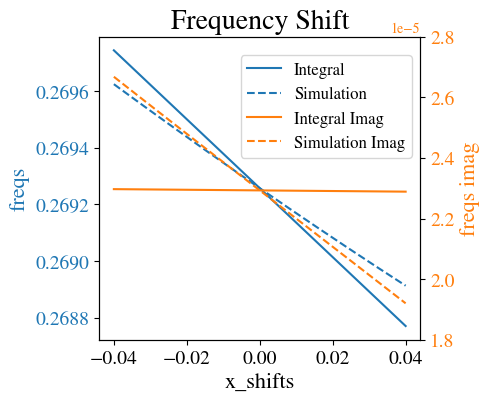

In [155]:
fig, ax1 = plt.subplots(figsize=(5,4))


ax1.set_xlabel('x_shifts', fontsize=16)
ax1.set_ylabel('freqs', color='C0', fontsize=16)
ax1.plot(x_shifts, freqs[5]+np.real(integrals), label='Integral', color='C0')
ax1.plot(x_shifts, freqs, label='Simulation', linestyle='--', color='C0')
ax1.tick_params(axis='y', labelcolor='C0', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('freqs imag', color='C1', fontsize=16)
ax2.plot(x_shifts, freqs_im[5]+np.imag(integrals), label='Integral Imag', color='C1')
ax2.plot(x_shifts, freqs_im, label='Simulation Imag', linestyle='--', color='C1')
ax2.set_ylim(1.8e-5,2.8e-5)
ax2.tick_params(axis='y', labelcolor='C1', labelsize=14)

fig.tight_layout()
fig.legend(bbox_to_anchor=(0.85,0.90), fontsize=12)
plt.title('Frequency Shift', fontsize=20)
plt.show()

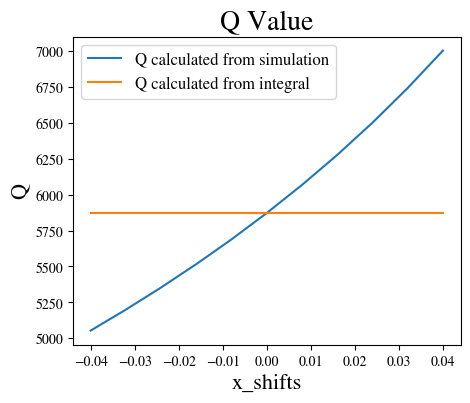

In [153]:
fig, ax = plt.subplots(figsize=(5,4))
plt.xlabel('x_shifts', fontsize=16)
plt.ylabel('Q', fontsize=16)
plt.plot(x_shifts,np.array(freqs)/2/np.array(freqs_im), label='Q calculated from simulation', color='C0')
plt.plot(x_shifts,(freqs[5]-np.real(integrals))/2/np.array(freqs_im[5]-np.imag(integrals)), label='Q calculated from integral', color='C1')
plt.legend(fontsize=12)
plt.title('Q Value', fontsize=20)
plt.show()

In [202]:
zs = np.linspace(0,40,100)
ex = []
ey = []
ez = []
for z in zs:
    fields,_,_ = gme_original.get_field_xy('E',0,120,phc_original.layers[0].d/2,xgrid=[z],ygrid=[0],component='xyz')

    ex.append(fields['x'])
    ey.append(fields['y'])
    ez.append(fields['z'])

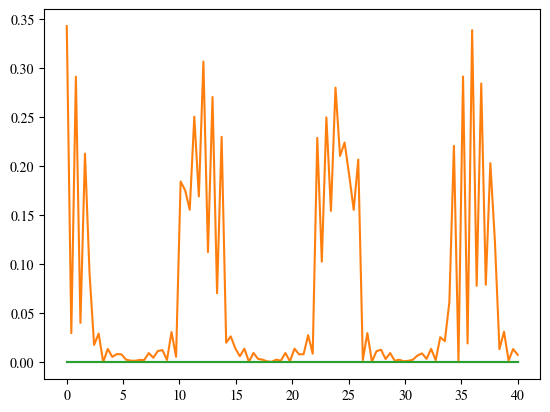

In [203]:
ex = np.array(ex).reshape(zs.shape)
ey = np.array(ey).reshape(zs.shape)
ez = np.array(ez).reshape(zs.shape)
plt.plot(zs,np.abs(ex))
plt.plot(zs,np.abs(ey))
plt.plot(zs,np.abs(ez))
plt.show()